## LinkNet: A Keras implementation for the Kaggle Carvana Image Masking Challenge 


Date created: Dec 20, 2017   
Last modified: Jan 20, 2018  
Tags: LinkNet, Keras, semantic segmentation


The LinkNet <a href="#ref1">[1]</a> model has been [implemented in pyTorch](https://github.com/e-lab/LinkNet). Here I have implemented a Keras version of the LinkNet. This is a sample run using data from the [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge) on Kaggle. The top winners in this challenge had great success with both the U-Net and LinkNet models.

## Import libraries

In [29]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import Input, Activation, BatchNormalization, concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split
import h5py
import random

import linknet
import losses
import augmentation

DATAPATH = "../data"

## LinkNet model


The LinkNet is a symmetric encoder-decoder architecture. The four encoder/decoder blocks are connected sequentially as well as with skip/bypass connections which link an encoder with the corresponding decoder layer.

**The Encoder block** uses [ResNet-18 blocks](#ref2). Each block has four 3x3 conv layers. The first of these convolutions is a *strided convolution* that downsamples the input by a factor of two. Following each convolution, *Batchnorm-ReLU* operations are performed.

**The Decoder block** is lightweight. It uses 1x1 convolutions to reduce the number of parameters. A *full convoluton* (Conv2DTranspose in Keras) is used for the upsampling.

The details of the network architecture are given in Section III of the [LinkNet paper](#ref1).

In [2]:
model = linknet.build_LinkNet(input_shape=(512,512, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
initial__conv (Conv2D)          (None, 256, 256, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
initial__bn (BatchNormalization (None, 256, 256, 64) 256         initial__conv[0][0]              
__________________________________________________________________________________________________
initial_act (Activation)        (None, 256, 256, 64) 0           initial__bn[0][0]                
__________________________________________________________________________________________________
max_poolin

## Data, Preprocessing, Augmentation

#### Data
The training dataset consists of 5088 images. Each car is presented in 16 fixed photo angles. The ground truth training mask images were converted from *.gif* to *.png* format so as to be compatible with the *OpenCV* library. 

The Carvana dataset can be found [here](https://www.kaggle.com/c/carvana-image-masking-challenge/data). The training images and ground truth masks are in the *train* and *train_masks* folders respectively. The test data was not used.

In [7]:
df_train = pd.read_csv(DATAPATH+'/train_masks.csv')

In [8]:
df_train = df_train.iloc[2:,:]
#df_train.head()

In [9]:
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [11]:
ids_train_split, ids_valid_split = \
    train_test_split(ids_train, test_size=0.2, random_state=42)

#### Preprocessing -- rescaling (input and mask data)
The original image resolution of 1918 x 1280 was downsampled to 512 x 512 using the *OpenCV* library functions.

In [3]:
input_width = 512
input_height = 512
max_epochs = 5
orig_width = 1918
orig_height= 1280
threshold  = 0.5

In [12]:
all_imgs  = {}
all_masks = {}

for id in ids_train:
    img  = cv2.imread(DATAPATH+'/train/{}.jpg'.format(id))
    img  = cv2.resize(img, (input_width, input_height))
    mask = cv2.imread(DATAPATH+'/train_masks_png/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (input_width, input_height))
    all_imgs[id]  = img
    all_masks[id] = mask

#### Augmentation

The following transformations using the *OpenCV* library were made:
* Hue, Saturation, Value using randomHueSaturationValue
* Shift, Scale, Rotate using randomShiftScaleRotate
* Horizontal flips using randomHorizontalFlip

## Training

In [15]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(list(ids_train_split), len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                img = augmentation.randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = augmentation.randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = augmentation.randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [16]:
def valid_generator(val_batch_size):
    while True:
        for start in range(0, len(ids_valid_split), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img  = all_imgs[id]
                mask = all_masks[id]
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [18]:
train_batch_size = 6
val_batch_size   = 16

In [19]:
callbacks = [ReduceLROnPlateau(monitor='val_dice_coef',
                               factor=0.2,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_coef',
                             filepath='../weights/best_weights_linknet_1.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))


Epoch 1/5
 - 395s - loss: 1.1837 - dice_coef: 0.9106 - val_loss: 0.7282 - val_dice_coef: 0.9767
Epoch 2/5
 - 285s - loss: 0.4947 - dice_coef: 0.9793 - val_loss: 0.3354 - val_dice_coef: 0.9818
Epoch 3/5
 - 285s - loss: 0.2512 - dice_coef: 0.9836 - val_loss: 0.1952 - val_dice_coef: 0.9858
Epoch 4/5
 - 285s - loss: 0.1664 - dice_coef: 0.9857 - val_loss: 0.1435 - val_dice_coef: 0.9874
Epoch 5/5
 - 285s - loss: 0.1319 - dice_coef: 0.9870 - val_loss: 0.1187 - val_dice_coef: 0.9888


In [20]:
model.load_weights('../weights/best_weights_linknet_1.hdf5')

In [25]:
model.compile(optimizer=RMSprop(lr=0.00001), loss=losses.bce_dice_loss, 
              metrics=[losses.dice_coef])

In [26]:
max_epochs = 20

In [27]:
callbacks = [ReduceLROnPlateau(monitor='val_dice_coef',
                               factor=0.2,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_coef',
                             filepath='../weights/best_weights_linknet_1.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/20
 - 290s - loss: 0.1168 - dice_coef: 0.9888 - val_loss: 0.1137 - val_dice_coef: 0.9897
Epoch 2/20
 - 285s - loss: 0.1136 - dice_coef: 0.9892 - val_loss: 0.1113 - val_dice_coef: 0.9898
Epoch 3/20
 - 285s - loss: 0.1111 - dice_coef: 0.9894 - val_loss: 0.1088 - val_dice_coef: 0.9901
Epoch 4/20
 - 285s - loss: 0.1087 - dice_coef: 0.9897 - val_loss: 0.1066 - val_dice_coef: 0.9902
Epoch 5/20
 - 285s - loss: 0.1066 - dice_coef: 0.9898 - val_loss: 0.1045 - val_dice_coef: 0.9904
Epoch 6/20
 - 285s - loss: 0.1045 - dice_coef: 0.9900 - val_loss: 0.1027 - val_dice_coef: 0.9904
Epoch 7/20
 - 285s - loss: 0.1027 - dice_coef: 0.9900 - val_loss: 0.1009 - val_dice_coef: 0.9905
Epoch 8/20
 - 285s - loss: 0.1009 - dice_coef: 0.9902 - val_loss: 0.0992 - val_dice_coef: 0.9906
Epoch 9/20
 - 285s - loss: 0.0992 - dice_coef: 0.9903 - val_loss: 0.0974 - val_dice_coef: 0.9908
Epoch 10/20
 - 284s - loss: 0.0976 - dice_coef: 0.9904 - val_loss: 0.0962 - val_dice_coef: 0.9907
Epoch 11/20
 - 285s - loss: 0

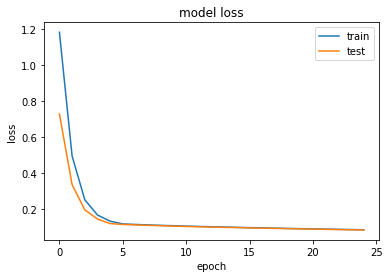

In [50]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show();

## Remarks

The LinkNet was designed to be efficient for real-time semantic segmentation applications, i.e. to obtain near state-of-the-art scores without compromising processing time. In this run, each epoch took ~4-5 minutes with a NVIDIA Tesla K80 GPU. This is an order of magnitude faster than several custom U-Net models that were run using the same dataset/image resolution (the U-Net models took 40-50 mins/epoch). The U-Net models ranged from 3.6 - 8.5 million parameters; the LinkNet has 11.6 million parameters so in terms of processing time the LinkNet is a clear winner.   
In terms of the accuracy, while the U-Net models performed very well in the Carvana challenge, some of the top entries (the [first](http://blog.kaggle.com/2017/12/22/carvana-image-masking-first-place-interview/?utm_medium=social&utm_source=twitter.com&utm_campaign=carvana+winners+interview) and sixth place winners) used an ensemble of both U-Net and LinkNet models


## References and Further Reading 

<a name="ref1"></a>[1] [Chaurasia, Abhishek, Culurciello, Eugenio. "LinkNet: Exploiting Encoder Representations for Efficient Semantic Segmentation." arXiv:1707.03718v1(cs.CV)](https://arxiv.org/pdf/1707.03718.pdf)  

<a name="ref2"></a>[2] [He, Kaiming et al. "Deep Residual Learning for Image Recognition." arXiv:1512.03385 [cs.CV]](https://arxiv.org/pdf/1512.03385.pdf)

<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
Email:   meenas.mailbag@gmail.com   <br> 
Twitter: @meena_uvaca    <br>
</div>